In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkContext

import numpy as np

# Create a Spark session
spark = SparkSession.builder.appName("MySparkApp").getOrCreate()
sc = SparkContext.getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/12 18:38:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# This function returns and RDD where each line is a list containing a row of values 


# ReadFile function
def parallelReadFile(filename):
    # Read the file into an RDD
    rdd = sc.textFile(filename)

    # Assuming the first line of the CSV is the header
    header = rdd.first()

    # Use flatMap to filter out the header
    dataWithoutHeader = rdd.flatMap(lambda line: [] if line == header else [line])

    # Process the RDD to remove the first column and convert elements to float
    rdd_processed = dataWithoutHeader.map(lambda line: [float(item) for item in line.split(',')[1:]])

    return rdd_processed


In [3]:
# This function returns and RDD where each line is a string
'''

# ReadFile function
def parallelReadFile(filename):

    # Read the file into an RDD
    rdd = sc.textFile(filename)

    # Assuming the first line of the CSV is the header
    header = rdd.first()

    # Use flatMap to filter out the header
    dataWithoutHeader = rdd.flatMap(lambda line: [] if line == header else [line])

    def remove_first_column(line):
        columns = line.split(",")  # Split line by comma
        return ",".join(columns[1:])  # Join all but the first column

    # Apply the function to each line
    dataWithoutFirstColumn = dataWithoutHeader.map(remove_first_column)

    return dataWithoutFirstColumn

'''

'\n\n# ReadFile function\ndef parallelReadFile(filename):\n\n    # Read the file into an RDD\n    rdd = sc.textFile(filename)\n\n    # Assuming the first line of the CSV is the header\n    header = rdd.first()\n\n    # Use flatMap to filter out the header\n    dataWithoutHeader = rdd.flatMap(lambda line: [] if line == header else [line])\n\n    def remove_first_column(line):\n        columns = line.split(",")  # Split line by comma\n        return ",".join(columns[1:])  # Join all but the first column\n\n    # Apply the function to each line\n    dataWithoutFirstColumn = dataWithoutHeader.map(remove_first_column)\n\n    return dataWithoutFirstColumn\n\n'

In [3]:
#Testing of the read function
filename = 'data/tot_mnist_shuf.csv'
RDD_Xy = parallelReadFile(filename)


In [7]:
def serialAssign2cluster(centroids, x):
    distances = [np.sqrt(np.sum(np.square(x - centroid))) for centroid in centroids]
    # Find the index of the closest centroid
    closest_index = np.argmin(distances)
    return closest_index

In [15]:
def parallelKMeans(data, K, n_iter):    
    # Random initialization of centroids
    centroids = [np.random.rand(len(data.first())) for _ in range(K)]

    for n in range(n_iter):
        # Assign points to the nearest centroid
        cluster_assignments = data.map(lambda x: (serialAssign2cluster(centroids, x), x))

        # Calculate the new centroids
        centroid_sums = cluster_assignments.reduceByKey(lambda x, y: x + y).collect()
        centroid_counts = cluster_assignments.map(lambda x: (x[0], 1)).reduceByKey(lambda x, y: x + y).collect()
        
        new_centroids = []

        for i in range(K):
            # Get sum and count for each centroid
            sum_of_points = centroid_sums.get(i, np.zeros(len(data.first())))
            count_of_points = centroid_counts.get(i, 0)

            # Calculate the new centroid
            if count_of_points > 0:
                new_centroid = sum_of_points / count_of_points
            else:
                new_centroid = np.random.rand(len(data.first()))  

            new_centroids.append(new_centroid)

        centroids = new_centroids

    return centroids


In [4]:
def serialAssign2cluster(centroids, x):
    distances = [np.sqrt(np.sum(np.square(x - centroid))) for centroid in centroids]
    closest_index = np.argmin(distances)
    return (closest_index, np.array(x))

In [5]:

def parallelKMeans(data, K, n_iter):    
    centroids = [np.random.rand(len(data.first())) for _ in range(K)]

    for n in range(n_iter):
        # Assign points to the nearest centroid
        cluster_assignments = data.map(lambda x: serialAssign2cluster(centroids, x))

        # Perform sum and count in a single reduceByKey operation
        centroid_sum_count = cluster_assignments.map(lambda x: (x[0], (x[1], 1))).reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))

        
        mean_centroids_list = centroid_sum_count.map(lambda x: (x[1][0] / x[1][1])).collect()

        centroids = mean_centroids_list

    return centroids



In [8]:
centroids = parallelKMeans(RDD_Xy, 10, 10)

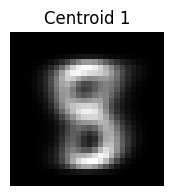

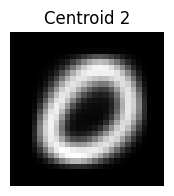

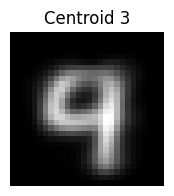

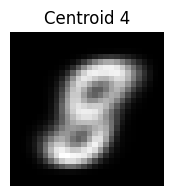

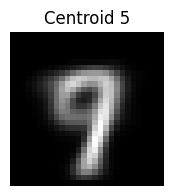

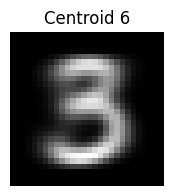

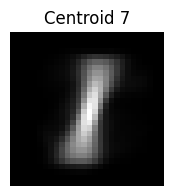

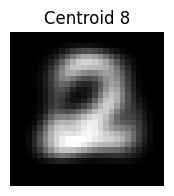

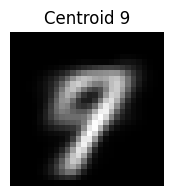

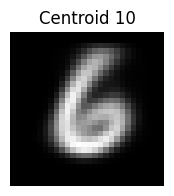

In [9]:
import matplotlib.pyplot as plt

# Assuming 'centroids' is a list of centroids, where each centroid is an array of pixel values
for i, centroid in enumerate(centroids):
    image = centroid.reshape((28, 28))  # reshape the centroid to the size of the image
    fig = plt.figure(figsize=(2, 2))  # you can adjust the figure size as needed
    plt.imshow(image, cmap='grey')  
    plt.title(f'Centroid {i+1}')
    plt.axis('off')  # turn off the axis
    plt.show()